In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [2]:
COVER = ["Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine", "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"]
FIELDS = ["id", "Elevation", "Aspect", "Slope", "Horizontal distance to water", "Vertical distance to water", "Horizontal distance to roadway", "Hillshade 9am", "Hillshade noon", "Hillshade 3pm", "Horizontal distance to fire points", "Wilderness Area", "Soil Type", "Cover Type"]
WILDERNESS = ["Rawah", "Neota", "Comanche Peak", "Cache La Poudra"]


In [3]:
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

def plot3d(c1, c2, c3, dataset=train, cts=None):
    threedee = plt.figure(figsize=(16,8)).gca(projection='3d')
    cover_types = np.array(list(dataset.Cover_Type.values))
    if cts == None:
        ct_set = set(cover_types)
    else:
        ct_set = cts
    classes = COVER
    colors = ["bo", "ro", "go", "co", "mo", "yo", "ko"]
    #colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
    
    for ct in ct_set:
        plt.plot([c1.iloc[i] for i, v in enumerate(cover_types) if v == ct], 
                 [c2.iloc[i] for i, v in enumerate(cover_types) if v == ct],
                 [c3.iloc[i] for i, v in enumerate(cover_types) if v == ct],
                 colors[int(ct-1)], 
                 label=COVER[int(ct-1)], alpha=.7)
        #plt.title(title)
        plt.legend(framealpha=.5, markerscale=1)
        
def plotc(c1,c2, dataset=train, cts=None):
    fig = plt.figure(figsize=(16,8))
    cover_types = np.array(list(dataset.Cover_Type.values))
    if cts == None:
        ct_set = set(cover_types)
    else:
        ct_set = cts
    classes = COVER
    colors = ["bo", "ro", "go", "co", "mo", "yo", "ko"]
    #colors = ['b', 'c', 'y', 'm', 'r', 'g', 'k']
    
    for ct in ct_set:
        plt.plot([c1.iloc[i] for i, v in enumerate(cover_types) if v == ct], 
                 [c2.iloc[i] for i, v in enumerate(cover_types) if v == ct],
                 colors[int(ct-1)], 
                 label=COVER[int(ct-1)], alpha=.7)
        #plt.title(title)
        plt.legend(framealpha=.5, markerscale=1)

    plt.xlabel(c1.name)
    plt.ylabel(c2.name)
    
#plotc(train.Elevation, train.Vertical_Distance_To_Hydrology)
#plot3d(train12.Aspect_cos, train12.Elevation, train12.Slope, train12)

In [4]:
#Mainly copied from aguschin as posted from kaggle forum (both this section and parts of other sections)
train['EVDtH'] = train.Elevation-train.Vertical_Distance_To_Hydrology
test['EVDtH'] = test.Elevation-test.Vertical_Distance_To_Hydrology

train['EHDtH4'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.4
test['EHDtH4'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.4

train['EHDtH2'] = train.Elevation-train.Horizontal_Distance_To_Hydrology*0.2
test['EHDtH2'] = test.Elevation-test.Horizontal_Distance_To_Hydrology*0.2

train['Distance_to_Hydrology'] = (train['Horizontal_Distance_To_Hydrology']**2+train['Vertical_Distance_To_Hydrology']**2)**0.5
test['Distance_to_Hydrology'] = (test['Horizontal_Distance_To_Hydrology']**2+test['Vertical_Distance_To_Hydrology']**2)**0.5

train['Hydro_Fire_1'] = train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Fire_Points']
test['Hydro_Fire_1'] = test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Fire_Points']

train['Hydro_Fire_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Fire_Points'])
test['Hydro_Fire_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Fire_Points'])

train['Hydro_Road_1'] = abs(train['Horizontal_Distance_To_Hydrology']+train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_1'] = abs(test['Horizontal_Distance_To_Hydrology']+test['Horizontal_Distance_To_Roadways'])

train['Hydro_Road_2'] = abs(train['Horizontal_Distance_To_Hydrology']-train['Horizontal_Distance_To_Roadways'])
test['Hydro_Road_2'] = abs(test['Horizontal_Distance_To_Hydrology']-test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_1'] = abs(train['Horizontal_Distance_To_Fire_Points']+train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_1'] = abs(test['Horizontal_Distance_To_Fire_Points']+test['Horizontal_Distance_To_Roadways'])

train['Fire_Road_2'] = abs(train['Horizontal_Distance_To_Fire_Points']-train['Horizontal_Distance_To_Roadways'])
test['Fire_Road_2'] = abs(test['Horizontal_Distance_To_Fire_Points']-test['Horizontal_Distance_To_Roadways'])

In [5]:
def r(x):
    if x+180>360:
        return x-180
    else:
        return x+180

train['Aspect2'] = train.Aspect.map(r)
test['Aspect2'] = test.Aspect.map(r)

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import cross_validation

def test_extra_trees(X, y, n=100, mf=10):
    rf = ExtraTreesClassifier(n, random_state=5, max_features=mf)
    cv = cross_validation.ShuffleSplit(len(X), 5, .3, random_state=5)
    scores = cross_validation.cross_val_score(rf, X, y, cv=cv)
    print scores
    print "n = {}, sd = {:.4f}, mean = {:.4f}".format(n, np.std(scores), np.mean(scores))

def run_extra_trees(this_train=train, this_test=test, excluded=['Id', 'Cover_Type'], n=100, output=False,
                    mf=8, out_file='features_engineering_benchmark.csv'):
    et = ExtraTreesClassifier(n, max_features=mf, random_state=5)
    feature_cols = [col for col in this_train.columns if col not in excluded]
    X = this_train[feature_cols]
    y = this_train['Cover_Type']
    test_ids = this_test['Id']
    X_test = this_test[feature_cols]
    et.fit(X,y)
    
    if output:
        with open(out_file, "wb") as outfile:
            outfile.write("Id,Cover_Type\n")
            for e, val in enumerate(list(et.predict(X_test))):
                outfile.write("%s,%s\n"%(test_ids[e],val))
    return et
    
def test_extra_trees_reg(X, y):
    rf = ExtraTreesRegressor(100, random_state=5)
    cv = cross_validation.ShuffleSplit(len(X), 5, .3, random_state=5)
    scores = cross_validation.cross_val_score(rf, X, y, cv=cv)
    print scores
    print "n = {}, sd = {:.4f}, mean = {:.4f}".format(100, np.std(scores), np.mean(scores))

In [7]:
def test_set(dataset=train, excluded=['Cover_Type', 'Id'], mf=10):
    feature_cols = [col for col in dataset.columns if col not in excluded]
    X_train = dataset[feature_cols]
    y = dataset['Cover_Type']
    test_extra_trees(X_train, y, mf=mf)
#test_set()

In [8]:
#print np.count_nonzero(train.Hillshade_3pm)
#print len(train.Hillshade_3pm)

def fix_zeros():
    #Run extra trees regressor to predict what the seemingly in error 0-value entries of 
    #  Hillshade_3pm should be then update train and test sets with those values
    feature_cols = [col for col in train.columns if col not in ['Cover_Type','Id', 'Hillshade_3pm']]
    #print len(train)
    X_nonzero = train[train.Hillshade_3pm <> 0]
    X_zeros = train[train.Hillshade_3pm == 0]
    X_train = X_nonzero[feature_cols]
    y = X_nonzero['Hillshade_3pm']
    #test_extra_trees_reg(X_train, y)
    et = ExtraTreesRegressor(100)
    et.fit(X_train, y)
    train.loc[train.Hillshade_3pm == 0, 'Hillshade_3pm'] = et.predict(X_zeros[feature_cols])
    X_test = test[test.Hillshade_3pm == 0]
    test.loc[test.Hillshade_3pm == 0, 'Hillshade_3pm'] = et.predict(X_test[feature_cols])
fix_zeros()



In [7]:
train12 = train[(train['Cover_Type'] == 1) | (train['Cover_Type'] == 2)]

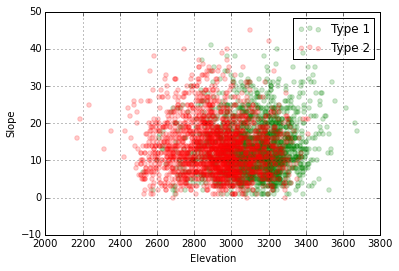

In [8]:
ax = train12.loc[train.Cover_Type == 1].plot(x = 'Elevation', y='Slope', 
                                             color='Green', alpha=.2, kind='scatter', label='Type 1')
train12.loc[train.Cover_Type == 2].plot(x = 'Elevation', y='Slope', 
                                        color='Red', alpha=.2, kind='scatter', label='Type 2', ax=ax)

In [11]:
train12['Aspect_radians'] = train12.Aspect*np.pi/180
train12['Aspect_sin'] = np.sin(train12['Aspect_radians'])
train12['Aspect_cos'] = np.cos(train12['Aspect_radians'])
train12['Aspect_tan'] = np.tan(train12['Aspect_radians'])
#Each of these fields seem to perform worse under cross validation of train12 data.
#Probably worth checking with full train data to see if any better there

In [12]:
#test_set(train, excluded=['Cover_Type', 'Id', 'Aspect2', 'Fire_Road_1', 'EHDtH2'])
#Slightly worse result on training set then when including all extra fields
#  However may be better on test set because possibly improved performance on ct 1, 2?
#test_set(train, excluded=['Cover_Type', 'Id'])
#Better official results when excluding only EHDtH2 of features (don't think I tried with all features)

[ 0.89351852  0.89197531  0.89528219  0.90035273  0.89726631]
n = 100, sd = 0.0029, mean = 0.8957
[ 0.89528219  0.89484127  0.89395944  0.89925044  0.90123457]
n = 100, sd = 0.0028, mean = 0.8969


In [14]:
plot3d(train12.Hillshade_9am, train12.Hillshade_3pm, train12.Hillshade_Noon, train12, cts=[2,1])
plt.show()
#It appears that lodgepole pine might be more towards the outer surface of the below shape than the spruce/fir
#  Hard to tell for sure since so much overlap of data, but worth exploring.
#Not sure off the top of my head how to get that into a convenient to use feature
#On further exploration, when I reverse the order of plotting, sprucefir appears to be on top which suggest the
#  apparent difference is from order of plotting rather than difference in placement

In [16]:
plot3d(np.tan(train12.Slope*np.pi/180), 
      train12.Vertical_Distance_To_Hydrology/train12.Horizontal_Distance_To_Hydrology, train12.Elevation, train12)
plot3d(np.tan(train12.Slope*np.pi/180), 
      train12.Vertical_Distance_To_Hydrology/train12.Horizontal_Distance_To_Hydrology, train12.Elevation, train12, [2,1])
plt.show()

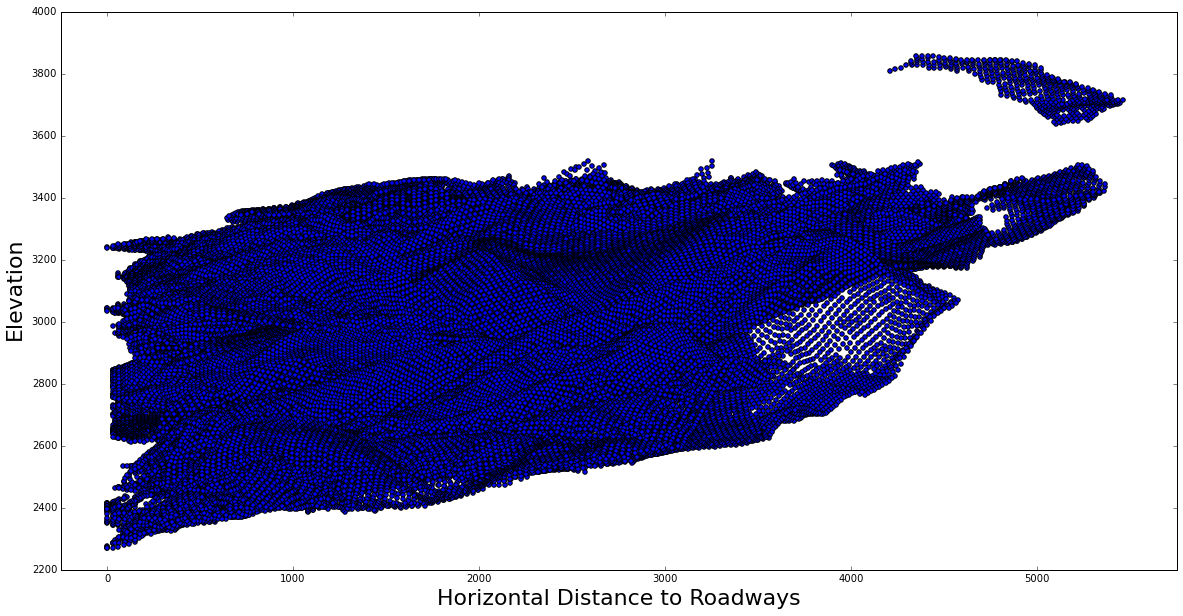

In [71]:
wild2 = test[test.Wilderness_Area3 ==1]
plt.figure(figsize=(20,10))
plt.xlabel("Horizontal Distance to Roadways", fontsize=22)
plt.ylabel("Elevation", fontsize=22)
plt.axis([-250, 5750, 2200, 4000])
plt.scatter(wild2.Horizontal_Distance_To_Roadways, wild2.Elevation)
#plt.scatter(wild2.Horizontal_Distance_To_Roadways, wild2.Horizontal_Distance_To_Fire_Points)

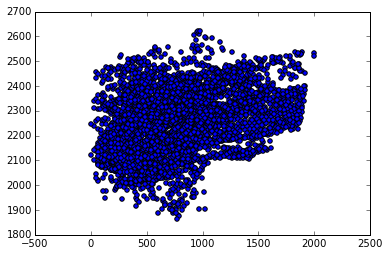

In [44]:
#wild2.plot(wild2.Horizontal_Distance_To_Fire_Points, wild2.Elevation)

